In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane_imager import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG imager, and set plate scale

In [19]:
config.read('scales_h2rg_imager.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))
arg_spaxel['plate_scale']=0.01
fov = (arg_spaxel['plate_scale']*arg_spaxel['detector_px'])**2
#arg_spaxel

## generate cube of PSFs using Keck pupil 

In [20]:
def create_cube(lamlist):
    #mag1 = magn(lamc)
    mag1 = 1.0
    cube = []
    lamprior = 0
    for lamtmp in lamlist:
        lamc = np.round(lamtmp,2).value
        if lamc==lamprior: cube.append(keck_psf)
        else:
            psf_file = 'psfs/ps_'+str(arg_spaxel['plate_scale'])+'/keck_psf_'+str(lamc)+'_imager.fits'
            if os.path.isfile(psf_file)==False:
                print('creating '+str(lamc))
                keckp = fits.getdata('keckpupil.fits')
                mpp = 10.0/len(keckp)
                mpp_des = 1.0/(2048.0*arg_spaxel['plate_scale'])*206265.0*lamc*1.0e-6
                keckt = scipy.ndimage.zoom(keckp, mpp/mpp_des, order=0)
                keckt = np.pad(keckt,1000)
                pupil = Pupil()
                pupil.pupil = keckt
                screen1 = np.zeros(pupil.pupil.shape)
            
            
                W = DFT_matrix(len(pupil.pupil), mag1)
                A = pupil.pupil * np.exp(1.j * screen1)
                out = abs(W.dot(A).dot(W))**2
                out /= np.sum(out, axis=(0,1))
                keck_psf = frebin(out, (nspax,nspax))
                fits.writeto(psf_file,np.array(keck_psf),clobber=True)
            else:
                #print('reading '+str(lamc))
                keck_psf = pyfits.getdata(psf_file)
            lamprior=lamc
            cube.append(keck_psf)
    return(np.array(cube))


## Set up target spectrum

In [21]:
###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 10.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)

####set this up as a Target
targ = Target(wav,I_lam)

## simulate 1s exposures of A stars

J
generating scales_imager_Astar_10pc_J_ps0.01.fits
[1.062474   1.07281281 1.08315162 1.09349043 1.10382924 1.11416805
 1.12450686 1.13484568 1.14518449 1.1555233  1.16586211 1.17620092
 1.18653973 1.19687854 1.20721735 1.21755616 1.22789497 1.23823378
 1.24857259 1.25891141 1.26925022 1.27958903 1.28992784 1.30026665
 1.31060546 1.32094427 1.33128308 1.34162189 1.3519607  1.36229951
 1.37263832 1.38297714 1.39331595 1.40365476 1.41399357 1.42433238
 1.43467119 1.44501   ] micron
(38, 2048, 2048)


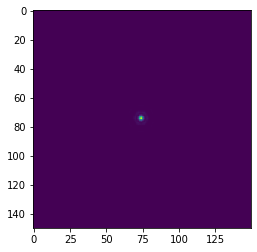

writing scales_imager_Astar_10pc_J_ps0.01.fits


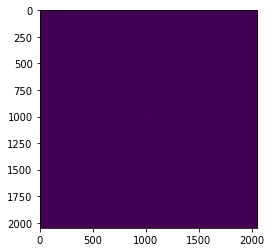

H
generating scales_imager_Astar_10pc_H_ps0.01.fits
[1.396846  1.4071891 1.4175322 1.4278753 1.4382184 1.4485615 1.4589046
 1.4692477 1.4795908 1.4899339 1.500277  1.5106201 1.5209632 1.5313063
 1.5416494 1.5519925 1.5623356 1.5726787 1.5830218 1.5933649 1.603708
 1.6140511 1.6243942 1.6347373 1.6450804 1.6554235 1.6657666 1.6761097
 1.6864528 1.6967959 1.707139  1.7174821 1.7278252 1.7381683 1.7485114
 1.7588545 1.7691976 1.7795407 1.7898838 1.8002269 1.81057   1.8209131
 1.8312562 1.8415993 1.8519424 1.8622855 1.8726286 1.8829717 1.8933148
 1.9036579 1.914001 ] micron
(51, 2048, 2048)


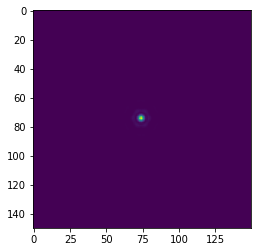

writing scales_imager_Astar_10pc_H_ps0.01.fits


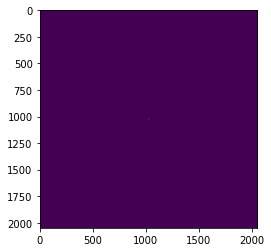

Ks
generating scales_imager_Astar_10pc_Ks_ps0.01.fits
[1.813156   1.82343376 1.83371152 1.84398927 1.85426703 1.86454479
 1.87482255 1.8851003  1.89537806 1.90565582 1.91593358 1.92621133
 1.93648909 1.94676685 1.95704461 1.96732236 1.97760012 1.98787788
 1.99815564 2.00843339 2.01871115 2.02898891 2.03926667 2.04954442
 2.05982218 2.07009994 2.0803777  2.09065545 2.10093321 2.11121097
 2.12148873 2.13176648 2.14204424 2.152322   2.16259976 2.17287752
 2.18315527 2.19343303 2.20371079 2.21398855 2.2242663  2.23454406
 2.24482182 2.25509958 2.26537733 2.27565509 2.28593285 2.29621061
 2.30648836 2.31676612 2.32704388 2.33732164 2.34759939 2.35787715
 2.36815491 2.37843267 2.38871042 2.39898818 2.40926594 2.4195437
 2.42982145 2.44009921 2.45037697 2.46065473 2.47093248 2.48121024
 2.491488  ] micron
(67, 2048, 2048)


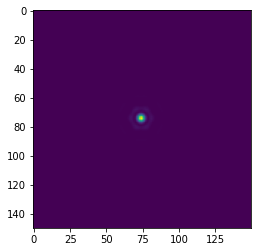

writing scales_imager_Astar_10pc_Ks_ps0.01.fits


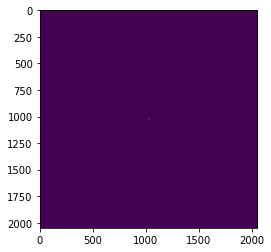

Lp
generating scales_imager_Astar_10pc_Lp_ps0.01.fits
[3.013262   3.02336718 3.03347237 3.04357755 3.05368274 3.06378792
 3.0738931  3.08399829 3.09410347 3.10420865 3.11431384 3.12441902
 3.13452421 3.14462939 3.15473457 3.16483976 3.17494494 3.18505013
 3.19515531 3.20526049 3.21536568 3.22547086 3.23557604 3.24568123
 3.25578641 3.2658916  3.27599678 3.28610196 3.29620715 3.30631233
 3.31641751 3.3265227  3.33662788 3.34673307 3.35683825 3.36694343
 3.37704862 3.3871538  3.39725899 3.40736417 3.41746935 3.42757454
 3.43767972 3.4477849  3.45789009 3.46799527 3.47810046 3.48820564
 3.49831082 3.50841601 3.51852119 3.52862637 3.53873156 3.54883674
 3.55894193 3.56904711 3.57915229 3.58925748 3.59936266 3.60946785
 3.61957303 3.62967821 3.6397834  3.64988858 3.65999376 3.67009895
 3.68020413 3.69030932 3.7004145  3.71051968 3.72062487 3.73073005
 3.74083524 3.75094042 3.7610456  3.77115079 3.78125597 3.79136115
 3.80146634 3.81157152 3.82167671 3.83178189 3.84188707 3.85199226
 3.86209

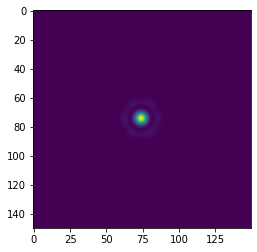

writing scales_imager_Astar_10pc_Lp_ps0.01.fits


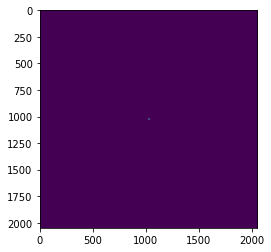

Ms
generating scales_imager_Astar_10pc_Ms_ps0.01.fits
[4.013827   4.02396226 4.03409751 4.04423277 4.05436803 4.06450329
 4.07463854 4.0847738  4.09490906 4.10504432 4.11517957 4.12531483
 4.13545009 4.14558535 4.1557206  4.16585586 4.17599112 4.18612637
 4.19626163 4.20639689 4.21653215 4.2266674  4.23680266 4.24693792
 4.25707318 4.26720843 4.27734369 4.28747895 4.29761421 4.30774946
 4.31788472 4.32801998 4.33815524 4.34829049 4.35842575 4.36856101
 4.37869626 4.38883152 4.39896678 4.40910204 4.41923729 4.42937255
 4.43950781 4.44964307 4.45977832 4.46991358 4.48004884 4.4901841
 4.50031935 4.51045461 4.52058987 4.53072513 4.54086038 4.55099564
 4.5611309  4.57126615 4.58140141 4.59153667 4.60167193 4.61180718
 4.62194244 4.6320777  4.64221296 4.65234821 4.66248347 4.67261873
 4.68275399 4.69288924 4.7030245  4.71315976 4.72329501 4.73343027
 4.74356553 4.75370079 4.76383604 4.7739713  4.78410656 4.79424182
 4.80437707 4.81451233 4.82464759 4.83478285 4.8449181  4.85505336
 4.865188

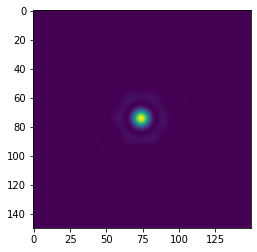

writing scales_imager_Astar_10pc_Ms_ps0.01.fits


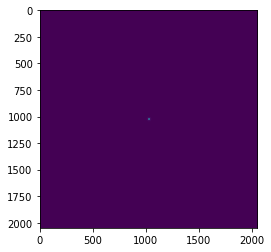

In [24]:
bands = ['J','H','Ks','Lp','Ms']
for band in bands:
    print(band)
    ofile = 'scales_imager_Astar_10pc_'+band+'_ps'+str(arg_spaxel['plate_scale'])+'.fits'
    ofile_sky = 'scales_imager_sky_'+band+'_ps'+str(arg_spaxel['plate_scale'])+'.fits'
    if os.path.isfile(ofile_sky)==False:
        print('generating '+ofile)
    
        nspax = arg_spaxel['detector_px']

    
        vapor = 1 #PWV in mm
        airmass = 1 
        skybg = SkyBG(vapor,airmass)
        skytrans = SkyTrans(vapor,airmass)
        atmodisp = AtmoDispersion(90,20,600)

        telAO_emissivities = [0.4]
        telAO_temps = [285*u.K]
        scales_trans = [0.616]
        inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
        qe = QE(0.88) ##detector 6 is ~0.8, detector 8 is 0.88 -- testing "worst case" for saturation using detector 8
    
    
        filt = ImagerFilter(filename='nirc2_'+band+'.txt')
        dit = 1 ###integration time in seconds
    
        ####organize all these and pass to focal_plane 
        args_new = {
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe,
            'FOV':fov, ###fov in square arcsec
            'area':arg_spaxel['area'],
            'DetectorPix':2048
                }
        fp = FocalPlaneImager(args_new)
        print(fp.lam)
    
    
        cube = create_cube(fp.lam)
        print(cube.shape)
        plt.imshow(cube[0][950:1100,950:1100])
        plt.show()
    
    
        raw_sky = fp.get_fp(dit*u.s,return_full=True,bg_off=False, return_phots=True) ###for sky only
        raw = fp.get_fp(dit*u.s,Target=targ, PSF=cube,return_full=True,bg_off=False, return_phots=True)#multiply by QE
        print('writing '+ofile)
        pyfits.writeto(ofile, np.array(raw),clobber=True)
        pyfits.writeto(ofile_sky, np.array(raw_sky),clobber=True)
        plt.imshow(raw)
        plt.show()
    else: 
        raw = pyfits.getdata(ofile)
        raw_sky = pyfits.getdata(ofile_sky)
        
        
        

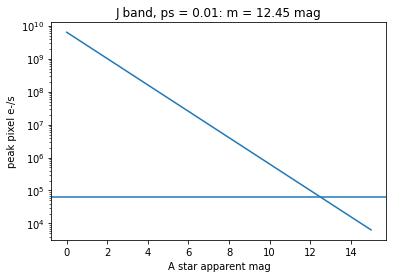

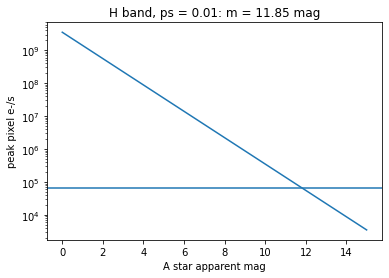

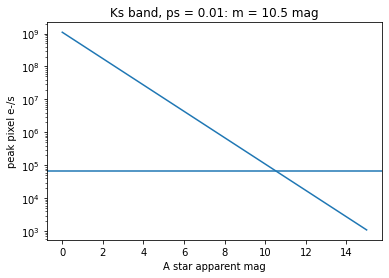

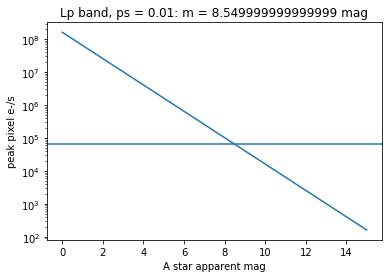

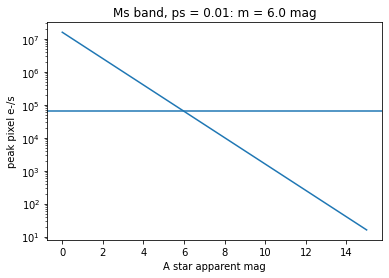

In [25]:
for band in bands:
    ofile = 'scales_imager_Astar_10pc_'+band+'_ps'+str(arg_spaxel['plate_scale'])+'.fits'
    raw = pyfits.getdata(ofile)
    im = raw.copy()
    mpixs = []
    f = plt.figure()
    amags = np.linspace(0.0,15.0,101)
    for amag in amags:
        im2 = im * 10**(-amag/2.5)
        mpix = np.max(im2)
        mpixs.append(mpix)
    mpixs = np.array(mpixs)
    mlim = amags[np.where(np.abs(mpixs-65000.0)==np.min(np.abs(mpixs-65000.)))][0]
    plt.title(band + ' band, ps = '+str(arg_spaxel['plate_scale'])+': m = '+str(mlim)+' mag')
    plt.plot(amags,mpixs)
    plt.xlabel('A star apparent mag')
    plt.ylabel('peak pixel e-/s')
    plt.yscale('log')
    plt.axhline(65000)
    plt.savefig('Astar_imager_maglimit_'+band+'_'+str(arg_spaxel['plate_scale'])+'.png')
    plt.show()
    mpixs = np.array(mpixs)
    mlim = amags[np.where(np.abs(mpixs-65000.0)==np.min(np.abs(mpixs-65000.)))]